# sarima Forecasting

## Importing the libraries

In [82]:
import os
from datetime import datetime
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd


## Importing the dataset

In [83]:
# pyspark_df = spark.table("sd_bdc_demo.sarima_time_series_forecasting.2_am_workday_historic_time_series_updated_data")
# pyspark_df.display()
# df = pyspark_df.toPandas()

In [84]:
df = pd.read_csv("2_service_now_historic_time_series_updated_data/2_service_now_historic_time_series_updated_data.csv")


In [85]:
print(df.head())

   Asset_Number Incident_Date  Gap_Days
0        100080    2021-04-14       NaN
1        100080    2021-04-15       0.0
2        100080    2021-04-16       0.0
3        100080    2021-04-17       0.0
4        100080    2021-04-18       0.0


In [86]:
print(df.columns)

Index(['Asset_Number', 'Incident_Date', 'Gap_Days'], dtype='object')


In [87]:
print(df.dtypes)

Asset_Number       int64
Incident_Date     object
Gap_Days         float64
dtype: object


In [88]:
df['Incident_Date'] = pd.to_datetime(df['Incident_Date'])

In [89]:
print(df.dtypes)

Asset_Number              int64
Incident_Date    datetime64[ns]
Gap_Days                float64
dtype: object


In [90]:
print(df.shape)

(121516, 3)


In [91]:
print(df['Incident_Date'])

0        2021-04-14
1        2021-04-15
2        2021-04-16
3        2021-04-17
4        2021-04-18
            ...    
121511   2024-04-14
121512   2024-04-15
121513   2024-04-16
121514   2024-04-17
121515   2024-04-18
Name: Incident_Date, Length: 121516, dtype: datetime64[ns]


### Drop null rows

In [92]:
df = df.dropna()

In [93]:
print(df.shape)

(121405, 3)


## Different Data Frame For Individual assets

In [94]:
unique_assets = df['Asset_Number'].unique()
print(unique_assets)

[100080 100081 300006 300007 300008 300009 300010 300011 300012 300013
 300014 300015 300016 300017 300018 300019 300020 300021 300022 300023
 300024 300025 300026 300027 300028 300029 300030 300031 300032 300033
 300034 300035 300036 300037 300038 300039 600053 600054 600055 600056
 600057 600058 600059 600060 600061 600062 600063 600064 600065 600066
 600067 600068 600069 600070 600071 600072 600073 600074 600075 600076
 600077 600078 600079 600080 600081 600082 600083 600084 600085 600086
 600087 600088 600089 600090 600091 600092 600093 600094 600095 600096
 600097 600098 600099 600100 600101 600102 600103 600104 600105 600106
 600107 600108 600109 600110 600111 600112 600113 600114 600115 600116
 600117 600118 600119 600120 600121 600122 600123 600124 600125 600126
 600127]


In [95]:
asset_dfs = {}

for asset_id in unique_assets:
    asset_df = df[df['Asset_Number'] == asset_id]

    asset_dfs[asset_id] = asset_df

In [96]:
individual_asset = asset_dfs[600100]
print(individual_asset)

       Asset_Number Incident_Date  Gap_Days
90874        600100    2021-04-06       0.0
90875        600100    2021-04-07       0.0
90876        600100    2021-04-08       0.0
90877        600100    2021-04-09       4.0
90878        600100    2021-04-10       1.0
...             ...           ...       ...
91962        600100    2024-03-29       3.0
91963        600100    2024-03-30       1.0
91964        600100    2024-03-31       0.0
91965        600100    2024-04-01       0.0
91966        600100    2024-04-02       3.0

[1093 rows x 3 columns]


In [97]:
print(individual_asset.shape)

(1093, 3)


## Forecasting with SARIMAX But without exogenous variable

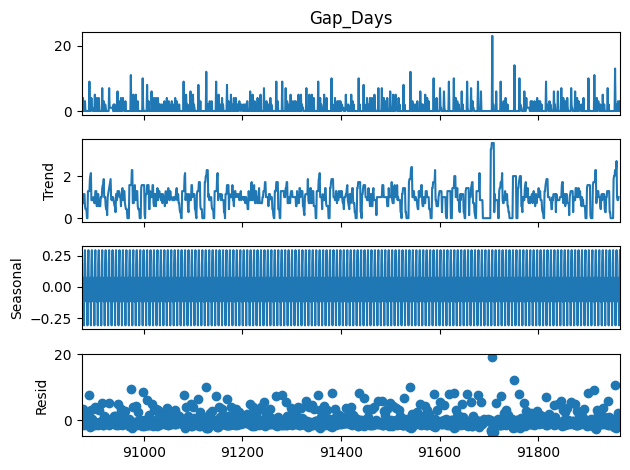

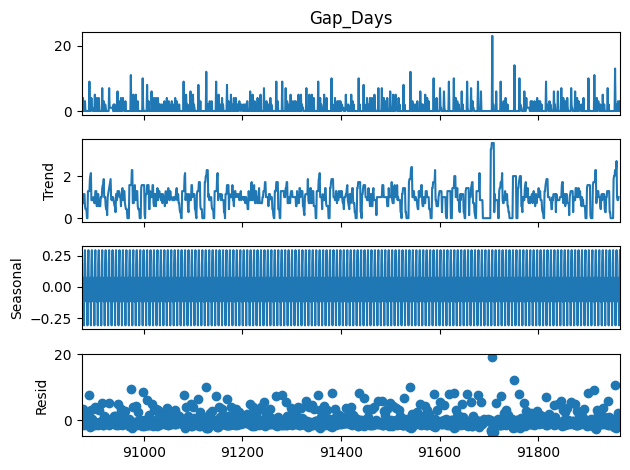

In [98]:
from statsmodels.tsa.seasonal import seasonal_decompose
decomp = seasonal_decompose(individual_asset['Gap_Days'], model='additive', period=7)
decomp.plot()


In [99]:
from statsmodels.tsa.statespace.sarimax import SARIMAX
from sklearn.metrics import mean_absolute_percentage_error, mean_squared_error
import pandas as pd

def forecast_sarima(asset_df, steps=30):
    asset_df = asset_df.copy()
    asset_df['Incident_Date'] = pd.to_datetime(asset_df['Incident_Date'])
    asset_df = asset_df.sort_values('Incident_Date').set_index('Incident_Date')
    y = asset_df['Gap_Days']

    train = y.iloc[:-steps]
    test = y.iloc[-steps:]

    model = SARIMAX(train, order=(1, 1, 1), seasonal_order=(0, 0, 0, 0), 
                    enforce_stationarity=False, enforce_invertibility=False)
    model_fit = model.fit(disp=False)

    forecast = model_fit.forecast(steps=steps)

    # Compute residuals on training data
    residuals = model_fit.resid
    residuals_df = residuals.reset_index()
    residuals_df.columns = ['Incident_Date', 'residual_value']

    # Metrics
    aic = model_fit.aic
    mape = mean_absolute_percentage_error(test, forecast)
    rmse = np.sqrt(mean_squared_error(test, forecast))

    return forecast, {
        'AIC': aic,
        'MAPE': mape,
        'RMSE': rmse,
        'ARIMA_order': model_fit.model_orders,
        'residuals': residuals_df
    }

In [100]:
asset_forecasts = {}
asset_metrics = {}
all_residuals = []

for asset_id, asset_df in asset_dfs.items():
    try:
        forecast, metrics = forecast_sarima(asset_df)
        asset_forecasts[asset_id] = forecast
        asset_metrics[asset_id] = metrics

        # Add residuals to the master list
        residual_df = metrics['residuals'].copy()
        residual_df['Asset_Number'] = asset_id
        all_residuals.append(residual_df)

    except Exception as e:
        print(f"Failed for Asset {asset_id}: {e}")


c:\Users\LakshmanNavaneethakr\Downloads\lakshmansierra-git\poc_service_now\.venv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
c:\Users\LakshmanNavaneethakr\Downloads\lakshmansierra-git\poc_service_now\.venv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
c:\Users\LakshmanNavaneethakr\Downloads\lakshmansierra-git\poc_service_now\.venv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
c:\Users\LakshmanNavaneethakr\Downloads\lakshmansierra-git\poc_service_now\.venv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D wi

In [101]:
print(type(asset_forecasts))

<class 'dict'>


In [102]:
print(asset_forecasts.items())

dict_items([(np.int64(100080), 2024-03-11    1.139958
2024-03-12    0.977955
2024-03-13    1.000978
2024-03-14    0.997706
2024-03-15    0.998171
2024-03-16    0.998105
2024-03-17    0.998114
2024-03-18    0.998113
2024-03-19    0.998113
2024-03-20    0.998113
2024-03-21    0.998113
2024-03-22    0.998113
2024-03-23    0.998113
2024-03-24    0.998113
2024-03-25    0.998113
2024-03-26    0.998113
2024-03-27    0.998113
2024-03-28    0.998113
2024-03-29    0.998113
2024-03-30    0.998113
2024-03-31    0.998113
2024-04-01    0.998113
2024-04-02    0.998113
2024-04-03    0.998113
2024-04-04    0.998113
2024-04-05    0.998113
2024-04-06    0.998113
2024-04-07    0.998113
2024-04-08    0.998113
2024-04-09    0.998113
Freq: D, Name: predicted_mean, dtype: float64), (np.int64(100081), 2024-03-19    1.135476
2024-03-20    0.981646
2024-03-21    1.002487
2024-03-22    0.999663
2024-03-23    1.000046
2024-03-24    0.999994
2024-03-25    1.000001
2024-03-26    1.000000
2024-03-27    1.000000
2024-

In [103]:
print(asset_forecasts[600100])

2024-03-04    1.147043
2024-03-05    0.977138
2024-03-06    1.002305
2024-03-07    0.998577
2024-03-08    0.999130
2024-03-09    0.999048
2024-03-10    0.999060
2024-03-11    0.999058
2024-03-12    0.999058
2024-03-13    0.999058
2024-03-14    0.999058
2024-03-15    0.999058
2024-03-16    0.999058
2024-03-17    0.999058
2024-03-18    0.999058
2024-03-19    0.999058
2024-03-20    0.999058
2024-03-21    0.999058
2024-03-22    0.999058
2024-03-23    0.999058
2024-03-24    0.999058
2024-03-25    0.999058
2024-03-26    0.999058
2024-03-27    0.999058
2024-03-28    0.999058
2024-03-29    0.999058
2024-03-30    0.999058
2024-03-31    0.999058
2024-04-01    0.999058
2024-04-02    0.999058
Freq: D, Name: predicted_mean, dtype: float64


### Saving all asset residual data in a table

## 🔴 NOTE
- `residual value` = `Actual Annual_load_cost_per_month` - `predicted Annual_load_cost_per_month` <br> 
of each train data of `288` historic data
- `residual value should be as close to zero as possible`

In [104]:
# Combine all residuals into one DataFrame
residuals_combined_df = pd.concat(all_residuals, ignore_index=True)

# Optional: sort and format
residuals_combined_df = residuals_combined_df[['Asset_Number', 'Incident_Date', 'residual_value']]


In [105]:
# Create the folder if it doesn't exist
os.makedirs("3_3_service_now_sarima_residuals_data", exist_ok=True)

# Save the Excel file inside the folder
residuals_combined_df.to_csv("3_3_service_now_sarima_residuals_data/3_3_service_now_sarima_residuals_data.csv", index=False)

In [106]:
# spark_df = spark.createDataFrame(residuals_combined_df)
# spark_df.write.mode("overwrite").saveAsTable("sd_bdc_demo.sarima_time_series_forecasting.3_3_service_now_sarima_residuals_data")

### Saving all asset ACF data in a table

## 🔴 NOTE
- `Lag` = How far back you are looking in time (e.g., 1 month ago, 2 months ago, etc.)
- `Autocorrelation` = How strongly the series is correlated with its own past values
- `ACF should be as close to zero as possible (except at lag 0)`

## 📌 Guidelines to choose `nlags`
| Scenario                       | Suggested `nlags`                   |
| ------------------------------ | ----------------------------------- |
| Short-term trend check         | 10–20                               |
| Monthly data with seasonality  | ≥ 12 (check for 12-month patterns)  |
| Quarterly data                 | ≥ 4 or 8                            |
| Long series (e.g., 300 points) | Up to 40–50 or more                 |
| Residual analysis              | 12–20 (slightly > forecast horizon) |

## ✅ Interpretation-1
| Lag (k) | Meaning                                                           | Expected ACF Value                              |
| ------- | ----------------------------------------------------------------- | ----------------------------------------------- |
| 0       | Correlation of series with itself                                 | Always 1                                        |
| 1       | Correlation with value 1 step before (e.g., 1 month ago)          | High if trend/seasonality exists, else low      |
| 2       | Correlation with value 2 steps before                             | Usually lower than lag 1 unless there's pattern |
| ...     | ...                                                               | Decreasing or oscillating depending on data     |
| 12      | Monthly seasonality — high ACF if pattern repeats every 12 months | High if strong seasonality                      |
| ≥ 13    | Less meaningful unless long-term memory or seasonality persists   | Usually low                                     |

## ✅ Interpretation-2
| Lag | Expected ACF                                            |
| --- | ------------------------------------------------------- |
| 0   | 1 (always)                                              |
| ≥1  | **Close to 0** — means model has captured all structure |



In [107]:
residuals_df = pd.concat(all_residuals).reset_index(drop=True)

In [108]:
from statsmodels.tsa.stattools import acf

acf_rows = []

for asset_id in residuals_df['Asset_Number'].unique():
    asset_resid = residuals_df[residuals_df['Asset_Number'] == asset_id]
    asset_resid_sorted = asset_resid.sort_values('Incident_Date')
    acf_values = acf(asset_resid_sorted['residual_value'], nlags=20)

    for lag, val in enumerate(acf_values):
        acf_rows.append({
            'Asset_Number': asset_id,
            'Lag': lag,
            'ACF_Value': round(val, 4)
        })

acf_df = pd.DataFrame(acf_rows)


In [109]:
# Create the folder if it doesn't exist
os.makedirs("3_4_service_now_sarima_acf_data", exist_ok=True)

# Save the Excel file inside the folder
acf_df.to_csv("3_4_service_now_sarima_acf_data/3_4_service_now_sarima_acf_data.csv", index=False)

In [110]:
# spark_df = spark.createDataFrame(acf_df)
# spark_df.write.mode("overwrite").saveAsTable("sd_bdc_demo.sarima_time_series_forecasting.3_4_service_now_sarima_acf_data")

### Metrics for each asset

In [111]:
print(f"Asset 600100 Metrics: {asset_metrics[600100]}")


Asset 600100 Metrics: {'AIC': np.float64(4646.013772265485), 'MAPE': 3318868319237861.0, 'RMSE': np.float64(2.6600922421485156), 'ARIMA_order': {'trend': 0, 'exog': 0, 'ar': 1, 'ma': 1, 'seasonal_ar': 0, 'seasonal_ma': 0, 'reduced_ar': 1, 'reduced_ma': 1, 'exog_variance': 0, 'measurement_variance': 0, 'variance': 1}, 'residuals':      Incident_Date  residual_value
0       2021-04-06        0.000000
1       2021-04-07        0.000000
2       2021-04-08        0.000000
3       2021-04-09        4.000000
4       2021-04-10        0.259164
...            ...             ...
1058    2024-02-28        0.592110
1059    2024-02-29       -1.000945
1060    2024-03-01        0.851876
1061    2024-03-02       -0.852680
1062    2024-03-03       -1.148124

[1063 rows x 2 columns]}


### Saving all asset metrics in a table

In [112]:
rows = []

for asset_id, metrics in asset_metrics.items():
    ar = metrics['ARIMA_order'].get('ar', '?')
    d = metrics['ARIMA_order'].get('trend', '?')
    ma = metrics['ARIMA_order'].get('ma', '?')

    seasonal_ar = metrics['ARIMA_order'].get('seasonal_ar', '?')
    seasonal_d = metrics['ARIMA_order'].get('seasonal_d', '?')  # assumed seasonal differencing
    seasonal_ma = metrics['ARIMA_order'].get('seasonal_ma', '?')
    s = metrics['ARIMA_order'].get('seasonal_period', '?')
    
    rows.append({
        'Asset_ID': asset_id,
        'AIC_unitless': round(float(metrics['AIC']), 2),
        'MAPE_%': round(float(metrics['MAPE']) * 100, 2),
        'RMSE_$': round(float(metrics['RMSE']), 2),
        'ARIMA_order': f"({ar},{d},{ma})",
        'Seasonal_order': f"({seasonal_ar},{seasonal_d},{seasonal_ma},{s})"
    })

metrics_df_clean = pd.DataFrame(rows)


In [113]:
# Create the folder if it doesn't exist
os.makedirs("3_1_service_now_sarima_metrics_data", exist_ok=True)

# Save the Excel file inside the folder
metrics_df_clean.to_csv("3_1_service_now_sarima_metrics_data/3_1_service_now_sarima_metrics_data.csv", index=False)

In [114]:
# spark_df = spark.createDataFrame(metrics_df_clean)
# spark_df.write.mode("overwrite").saveAsTable("sd_bdc_demo.sarima_time_series_forecasting.3_1_service_now_sarima_metrics_data")

## Plot Prediction of Single asset

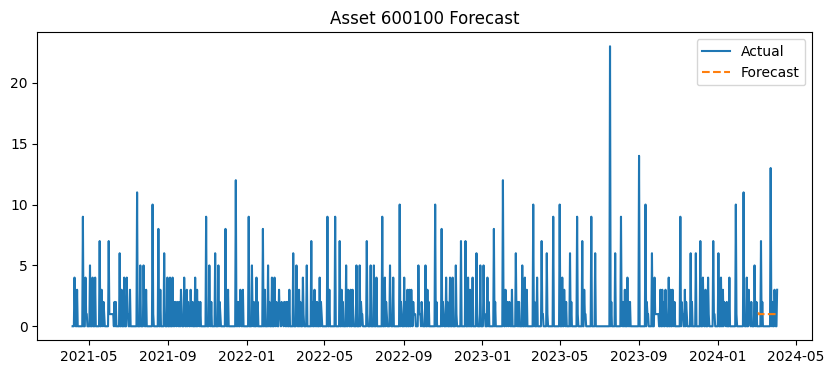

In [115]:
import matplotlib.pyplot as plt

asset_id = 600100
asset_df = asset_dfs[asset_id].copy()
asset_df['Incident_Date'] = pd.to_datetime(asset_df['Incident_Date'])
asset_df.set_index('Incident_Date', inplace=True)

forecast = asset_forecasts[asset_id]

plt.figure(figsize=(10, 4))
plt.plot(asset_df['Gap_Days'], label='Actual')
plt.plot(forecast, label='Forecast', linestyle='--')
plt.title(f'Asset {asset_id} Forecast')
plt.legend()
plt.show()

## Saving the Predicted Data

In [116]:
all_forecasts = []

for asset_id, forecast_series in asset_forecasts.items():
    for date, cost in forecast_series.items():
        all_forecasts.append({
            'Asset_ID': asset_id,
            'Incident_Date': date,
            'Gap_Days': round(cost, 0)
        })

forecast_df = pd.DataFrame(all_forecasts)

# Step 4: Sort and reset index (optional but clean)
forecast_df = forecast_df.sort_values(['Asset_ID', 'Incident_Date']).reset_index(drop=True)


In [117]:
print(forecast_df.head())

   Asset_ID Incident_Date  Gap_Days
0    100080    2024-03-11       1.0
1    100080    2024-03-12       1.0
2    100080    2024-03-13       1.0
3    100080    2024-03-14       1.0
4    100080    2024-03-15       1.0


In [118]:
forecast_df['Incident_Date'] = pd.to_datetime(forecast_df['Incident_Date'])

## Export Updated Excel

In [119]:
# Create the folder if it doesn't exist
os.makedirs("3_2_service_now_sarima_forecasted_data", exist_ok=True)

# Save the Excel file inside the folder
forecast_df.to_csv("3_2_service_now_sarima_forecasted_data/3_2_service_now_sarima_forecasted_data.csv", index=False)

In [120]:
# spark_df = spark.createDataFrame(forecast_df)
# spark_df.write.mode("overwrite").saveAsTable("sd_bdc_demo.sarima_time_series_forecasting.3_2_service_now_sarima_forecasted_data")